In [1]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip kagglecatsanddogs_5340.zip
!cat 'readme[1].txt'

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  
  inflating: PetImages/Dog/5523.jpg  
  inflating: PetImages/Dog/5524.jpg  
  inflating: PetImages/Dog/5525.jpg  

In [2]:
import glob
import torch
from torch.utils.data import Dataset
from skimage import io

import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class CatsAndDogsDataset(Dataset):
  def __init__(self,root_dir,transform=None):
    
    self.root_dir = root_dir
    self.transform = transform
    self.filepaths = list(glob.glob(f'{self.root_dir}/**/*.jpg', recursive=True))
    
    get_label = lambda s: int('Dog' in s)

    self.lookup_table = [(path,get_label(path))for path in self.filepaths]

  def __len__(self):
    return len(self.filepaths)
  
  def __getitem__(self,index):
    path, label = self.lookup_table[index]
    # ValueError: At least one stride in the given numpy array is negative, and 
    # tensors with negative strides are not currently supported. 
    # (You can probably work around this by making a copy of your array 
    # with array.copy().) 
    image = io.imread(path).copy()
    y_label = torch.tensor(label)

    if self.transform:
      image = self.transform(image)
    return (image,y_label)

In [5]:
learning_rate = 1e-3
batch_size = 32
num_epochs = 1

In [6]:
!rm -rf 'PetImages/Cat/10404.jpg' 'PetImages/Cat/666.jpg' 'PetImages/Dog/11702.jpg'

In [7]:
# RuntimeError: stack expects each tensor to be equal size, but got [3, 50, 50] at entry 0 and [1, 50, 50] at entry 13
# RuntimeError: stack expects each tensor to be equal size, but got [3, 50, 50] at entry 0 and [4, 50, 50] at entry 25

class CorretorAntiJelson:
  "po jelson, podia ter limpado esse dataset hein" 
  def __init__(self):
    pass
  def __call__(self, x):
    if x.size() != torch.Size((3,50,50)):
      return torch.zeros(3,50,50)
    return x

In [8]:
dataset = CatsAndDogsDataset(root_dir='PetImages/',transform=transforms.Compose([transforms.ToTensor(),transforms.Resize(100),transforms.RandomCrop(50),CorretorAntiJelson()]))
train_set, test_set = torch.utils.data.random_split(dataset, [20000,4997])
train_loader = DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

In [9]:
model = torchvision.models.googlenet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
model.fc = nn.Linear(in_features=1024, out_features=2, bias=True)
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [11]:
from torchsummary import summary
summary(model,train_set[0][0].size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 25]           9,408
       BatchNorm2d-2           [-1, 64, 25, 25]             128
       BasicConv2d-3           [-1, 64, 25, 25]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]           4,096
       BatchNorm2d-6           [-1, 64, 12, 12]             128
       BasicConv2d-7           [-1, 64, 12, 12]               0
            Conv2d-8          [-1, 192, 12, 12]         110,592
       BatchNorm2d-9          [-1, 192, 12, 12]             384
      BasicConv2d-10          [-1, 192, 12, 12]               0
        MaxPool2d-11            [-1, 192, 6, 6]               0
           Conv2d-12             [-1, 64, 6, 6]          12,288
      BatchNorm2d-13             [-1, 64, 6, 6]             128
      BasicConv2d-14             [-1, 6

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [13]:
model.train()
for epoch in range(num_epochs):
  for batch_id, (data,targets) in enumerate(train_loader):
    data = data.to(device)
    targets = targets.to(device)
    scores = model(data)
    loss = criterion(scores,targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

In [14]:
num_correct = 0
num_samples = 0
model.eval()
with torch.no_grad():
  for x,y in test_loader:
    x = x.to(device=device)
    y = y.to(device=device)
    scores = model(x)
    _,predictions = scores.max(1)
    num_correct += (predictions == y).sum()
    num_samples += predictions.size(0)
    print(f'{num_correct}/{num_samples} = {num_correct/num_samples}')

26/32 = 0.8125
50/64 = 0.78125
72/96 = 0.75
101/128 = 0.7890625
130/160 = 0.8125
153/192 = 0.796875
180/224 = 0.8035714626312256
205/256 = 0.80078125
228/288 = 0.7916666865348816
251/320 = 0.784375011920929
277/352 = 0.7869318127632141
301/384 = 0.7838541865348816
328/416 = 0.7884615659713745
355/448 = 0.7924107313156128
384/480 = 0.8000000715255737
410/512 = 0.80078125
435/544 = 0.7996323704719543
460/576 = 0.7986111044883728
484/608 = 0.7960526347160339
509/640 = 0.7953125238418579
533/672 = 0.793154776096344
560/704 = 0.7954545617103577
587/736 = 0.7975543737411499
616/768 = 0.8020833730697632
642/800 = 0.8025000095367432
665/832 = 0.7992788553237915
685/864 = 0.7928240895271301
708/896 = 0.7901785969734192
731/928 = 0.787715494632721
758/960 = 0.7895833849906921
781/992 = 0.7872983813285828
807/1024 = 0.7880859375
829/1056 = 0.7850378751754761
853/1088 = 0.7840073704719543
878/1120 = 0.7839285731315613
904/1152 = 0.7847222089767456
930/1184 = 0.7854729890823364
960/1216 = 0.7894737

tensor([[ 2.1781, -2.8894]], device='cuda:0', grad_fn=<AddmmBackward0>)

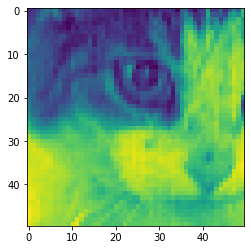

In [45]:
plt.imshow(test_set[100][0][0])
model.eval()
model(test_set[100][0].unsqueeze(0).to(device))

tensor([[-1.4672,  1.9152]], device='cuda:0', grad_fn=<AddmmBackward0>)

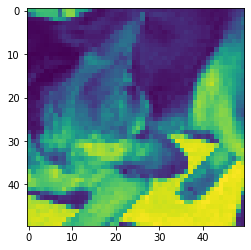

In [49]:
plt.imshow(test_set[1000][0][0])
model(test_set[1000][0].unsqueeze(0).to(device))